# Introduction to Water Observations from Space

| Authors:  | Bex Dunn|
|----------|----------------|
| Created: | May 16, 2019 |
| Last edited: | May 16, 2019 |

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

This notebook assumes you have cloned the dea-notebooks repository by following the instructions on [DEA notebooks using command line git](https://github.com/GeoscienceAustralia/dea-notebooks#dea-notebooks-using-command-line-git) or [DEA notebooks using Github](https://github.com/GeoscienceAustralia/dea-notebooks#dea-notebooks-using-github). If you didn't, you will need to download any scripts that fail in the first cell into your relative directory so that the notebook will have access to those scripts. `"../"` means the directory above the directory you are working in, and `"./"` means the current directory. 

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

__Background:__ Water Observations from Space (WOfS) is a suite of Australian continental surface water products. 


|WOfS products include:||
|----------|----------------|
| WOfS summary | this is the all-time summary |
|  WOfS filtered summary | the all time summary, checked against the confidence layer |
|  WOfS seasonal summaries | summaries for seasons |
| WOFLs (WOfS Feature Layers)|the daily WOfS slices |
 

__What does this notebook do?:__ This notebook introduces WOfS and demonstrates how to load and filter WOfS data using the DEA datacube. The data is then saved to NetCDF and GeoTIFF for analysis elsewhere.

__Datasets covered in this notebook:__

- Landsat 5
- Landsat 7
- Landsat 8
- UE - Unmixing Error
- Water Observations from Space (WOFs)
- WOfS Feature Layer (WOFL)


## What is WOfS? [[1, 2](#References)]

The Water Observations from Space products stored in DEA are at 25m x 25m resolution (the same as the Landsat surface reflectance products).

    
    
    
__No Data Values:__ 

### Limitations, Errors and Uncertainty:



## How to retrieve and plot the data

## Import modules from standard libraries, datacube and files
Select 'Trust this notebook' to import these modules.

In [5]:
%matplotlib inline

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

#modules for datacube
import datacube
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser, write_geotiff

#write to netcdf moved?

# Import external functions from dea-notebooks
sys.path.append('../10_Scripts/')
import DEAPlotting, DEADataHandling

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

### WOfS products available from Digital Earth Australia as at 16/05/2019:

In [28]:
# set datacube alias (just a string with what you're doing)
dc = datacube.Datacube(app='dc-WOfS')
#display product name and descriptions, where the name of the product contains 'wofs'
#products = dc.list_products()
display_columns = ['name', 'description']
dc_products = products[display_columns]
dc_products[dc_products['name'].str.contains("wofs")]

,name,description
id,,
77,wofs_albers,Historic Flood Mapping Water Observations from...
97,wofs_annual_summary,Water Observations from Space Annual Statistics
100,wofs_apr_oct_summary,Water Observations from Space April to October...
85,wofs_filtered_summary,Water Observations from Space Statistics confi...
101,wofs_nov_mar_summary,Water Observations from Space November to Marc...
84,wofs_summary,Water Observations from Space Statistics


### WOfS ancillary datasets (used to create wofs confidence)

In [7]:
dc_products[dc_products['description'].str.contains("wofs")]

,name,description
id,,
88,dsm,"dsm ancillary data for wofs confidence, 25 met..."
87,modis,Modis ancillary data for wofs confidence
86,mrvbf,MrVBF ancillary data for wofs confidence
89,urban_areas,urbanAreas ancillary data for wofs confidence


### Specify the *query* with the coordinates and date range

The *query* is what you are asking the datacube to return.

- **lat/lon:** Latitude and longitude of the area. e.g. Canberra = 'lat': (-35.25, -35.35), 'lon': (149.05, 149.17)
- **time:** Date range to fetch the scenes. The approximate time between two scenes is 16 days. If there is a location near a swath boundary, it may be captured in two passes and so there could be two images within the 16 day period.
    - You must know [the date(s) for which data is available](https://data.dea.gadevs.ga/ls7_nbar_scene) for each satellite/product, so that the query can be specified correctly. 
- **scene:** The index of the scene to be plotted. If the date range is < 16 days there may only be one scene, and the index must be specified as 0.

In [19]:
#the query is a dictionary where the keys are the spatio-temporal specs
query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'time':('2014-01-01', '2014-01-31')
        }

In [20]:
#load the data according to our query
#choose a mask proportion to look for a clear timestep
ds = DEADataHandling.load_clearlandsat(dc, query,product='fc',masked_prop=0.80)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 3 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


## WOfS feature layers (WOFLs) 

### load the wofs feature layers (wofls) 

In [23]:
#load the wofs feature layers (wofls) within the same query as Fractional cover, using 'like'
wofls = dc.load(product = 'wofs_albers', **query)

### Two ways of displaying what the values in the wofs data mean:
WOfS uses [bit flags](http://datacube-core.readthedocs.io/en/latest/dev/api/masking.html) to flag pixels as 'wet' or otherwise

In [24]:
masking.describe_variable_flags(wofls, with_pandas=True)

,bits,values,description
cloud,6,"{'0': False, '1': True}",Cloudy
cloud_shadow,5,"{'0': False, '1': True}",Cloud shadow
dry,"[7, 6, 5, 4, 3, 1, 0]",{'0': True},Clear and dry
high_slope,4,"{'0': False, '1': True}",High slope
nodata,0,{'1': True},No data
noncontiguous,1,"{'0': False, '1': True}",At least one EO band is missing over over/unde...
sea,2,"{'0': False, '1': True}",Sea
terrain_or_low_angle,3,"{'0': False, '1': True}",Terrain shadow or low solar angle
water_observed,7,"{'0': False, '1': True}",Classified as water by the decision tree
wet,"[7, 6, 5, 4, 3, 1, 0]",{'128': True},Clear and Wet


In [12]:
for key in wofls.water.flags_definition.keys():
    print('{}  {}'.format(key, wofls.water.flags_definition[key]))

dry  {'bits': [7, 6, 5, 4, 3, 1, 0], 'values': {'0': True}, 'description': 'Clear and dry'}
sea  {'bits': 2, 'values': {'0': False, '1': True}, 'description': 'Sea'}
wet  {'bits': [7, 6, 5, 4, 3, 1, 0], 'values': {'128': True}, 'description': 'Clear and Wet'}
cloud  {'bits': 6, 'values': {'0': False, '1': True}, 'description': 'Cloudy'}
nodata  {'bits': 0, 'values': {'1': True}, 'description': 'No data'}
high_slope  {'bits': 4, 'values': {'0': False, '1': True}, 'description': 'High slope'}
cloud_shadow  {'bits': 5, 'values': {'0': False, '1': True}, 'description': 'Cloud shadow'}
noncontiguous  {'bits': 1, 'values': {'0': False, '1': True}, 'description': 'At least one EO band is missing over over/undersaturated'}
water_observed  {'bits': 7, 'values': {'0': False, '1': True}, 'description': 'Classified as water by the decision tree'}
terrain_or_low_angle  {'bits': 3, 'values': {'0': False, '1': True}, 'description': 'Terrain shadow or low solar angle'}


In [ ]:
#FIXME color ramp

In [ ]:
#FIXME descriptions

### Here is what the WOFL mask looks like on one timestep:

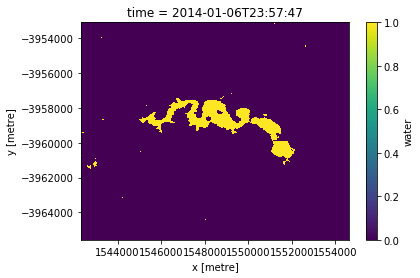

In [14]:
wetwofl = masking.make_mask(wofls, wet=True)
wetwofl.water.isel(time=0).plot()
#drywofl = masking.make_mask(wofls, dry=True)
#drywofl.water.isel(time=0).plot()

In [ ]:
wofs_filtered_summary

In [ ]:
wofs_annual_summary

### Edit save file path to choose where to save your output files

In [16]:
#save files to your home directory (add your outpath here if you want to change it)
savefilepath = os.path.expanduser('~/')

## Save Fractional Cover scenes to NetCDF


In [17]:
try:
    DEADataHandling.write_your_netcdf(unwofld, 'FC25', savefilepath+'FC25'+'.nc', crs = ds.crs)
#complain if the file already exists but don't fail    
except RuntimeError as err:
    print("RuntimeError: {0}".format(err))
print('wrote to netCDF' )

AttributeError: 'DataArray' object has no attribute 'units'

## Save Fractional Cover scenes to GeoTIFF


In [19]:
ds = unwofld
#write a geotiff to file for each timestep
if len(ds.time)==1:
    print('one timestep')
    #drop the time dimension for only one timestep
    #write the dataset without the data percentage to file
    ds1 = ds.squeeze()
    ds1 = ds1.drop('data_perc')
    write_geotiff(savefilepath+'FC25_'+'.tif', ds1)

elif len(ds.time)>1:
    print('multiple timesteps') 
    #remove data percentage as it breaks the geotiff writer
    ds = ds.drop('data_perc')
    for timestep in range(len(ds.time)):
        try:
            write_geotiff(savefilepath+'FC25_'+str(timestep)+'.tif', ds.isel(time =timestep))
            #complain if the file already exists but don't fail    
            print('wrote to GeoTIFF' )
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))

multiple timesteps
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF


## References
1. GA, 2015. *Fractional Cover (FC25) Product Description.* https://d28rz98at9flks.cloudfront.net/79676/Fractional_Cover_FC25_v1_5.PDF

